# Triple Checking Flux Map Computations

# Part 1 - Interpolating Stella's File to Odd-Timesteps

The first step is to take the **maximum density** measurements from the simulation, and interpolate them for the odd time-steps, using basic linear interpolation in log-log space.

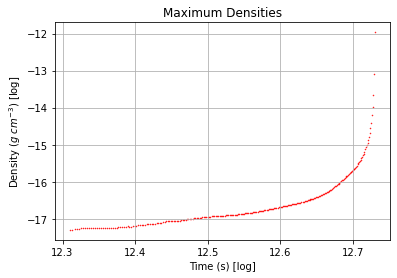

In [1]:
import numpy as np
data = np.loadtxt('/Users/samuelfielder/Documents/SyntheticObservations/simulations/_MD_0.4msun/File_Maxden_time_0.4msun.txt')
timesteps = data[:,0].astype(int)
log_time = np.log10(data[:,1]) # log quantities
log_maxrho = np.log10(data[:,2]) # log quantities

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(log_time, log_maxrho, marker='.', s=1, c='red', label='Original')
plt.grid(axis='both')
plt.ylabel(r'Density $(g \ cm^{-3})$ [log]')
plt.xlabel('Time (s) [log]')
plt.title('Maximum Densities')
plt.show()

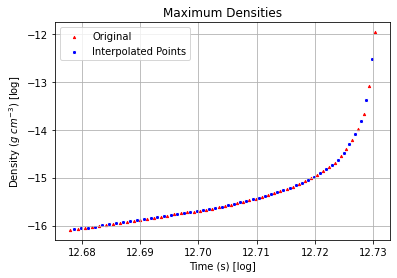

In [2]:
data = np.loadtxt('/Users/samuelfielder/Documents/SyntheticObservations/simulations/_MD_0.4msun/File_Maxden_time_0.4msun.txt', skiprows=200)
timesteps = data[:,0].astype(int)
log_time = np.log10(data[:,1]) # log quantities
log_maxrho = np.log10(data[:,2]) # log quantities

# create new timesteps from the range of current timesteps
new_timesteps = np.arange(timesteps[0], timesteps[-1]+1, 1) # want integer values here

# create interpolated time and maxrho
interp_log_time = np.interp(new_timesteps, timesteps, log_time)
interp_log_maxrho = np.interp(new_timesteps, timesteps, log_maxrho)

new_time = np.power(10, interp_log_time).round(0)
new_maxrho = np.power(10, interp_log_maxrho)

plt.figure()
plt.scatter(log_time, log_maxrho, marker='^', s=5, c='red', label='Original')
plt.scatter(interp_log_time[1::2], interp_log_maxrho[1::2], marker='x', s=5, c='blue', label='Interpolated Points')
plt.grid()
plt.ylabel(r'Density $(g \ cm^{-3})$ [log]')
plt.xlabel('Time (s) [log]')
plt.title('Maximum Densities')
plt.legend()
plt.show()

Finally, checking the final outputted txt file with the data array.

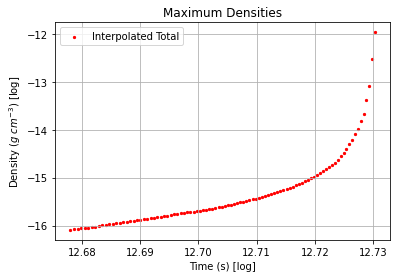

In [3]:
data = np.loadtxt('/Users/samuelfielder/Documents/SyntheticObservations/simulations/_MD_0.4msun/File_Maxden_time_0.4msun_interp.txt')
timesteps = data[:,0].astype(int)
log_time = np.log10(data[:,1]) # log quantities
log_maxrho = np.log10(data[:,2]) # log quantities

plt.figure()
plt.scatter(log_time, log_maxrho, c='red',s=5, label='Interpolated Total')
plt.grid()
plt.ylabel(r'Density $(g \ cm^{-3})$ [log]')
plt.xlabel('Time (s) [log]')
plt.title('Maximum Densities')
plt.legend()
plt.show()

# Part 2 - Computing Maximum Number Densities

Stella's file gives the maximum density of the simulation, and this needs to be translated into a maximum number density. This maximum number density is used to grab the correct model file, in order to compute the temperature for each pixel in the column density image.

The equation used is simply:

$$
n = \frac{\rho}{\mu \cdot m_H}
$$

This translates from the $g \ cm^{-3}$ unit into the $cm^{-3}$ unit for number density.

The following values are used for the computation:

* $\mu = 2.37$
* $m_H = 1.6735575 × 10^-24$ g

Taking a look specifically at the file that was generated for this data:

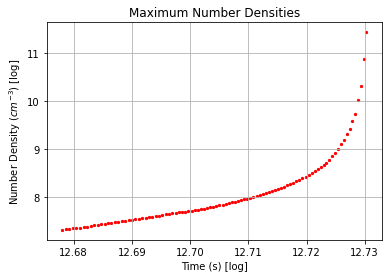

In [4]:
data = np.loadtxt('/Users/samuelfielder/Documents/SyntheticObservations/simulations/_MD_0.4msun/File_Max_n_time_0.4msun_interp.txt')

plt.figure()
plt.scatter(np.log10(data[:,1]), np.log10(data[:,3]), c='red',s=5, label='Number Density')
plt.grid()
plt.ylabel(r'Number Density $(cm^{-3})$ [log]')
plt.xlabel('Time (s) [log]')
plt.title('Maximum Number Densities')
plt.show()

# Part 3 - Creating the Flux Maps

## 3.1 - Loading Column Density Map

### NOTE: Will be using the following as the test image:
`mhdlev8_0.4_flatcol_20kau_0901_0.151293.fits`

This is so we can compare to the CASA Code that Mike has provided for the `simobserse` and `simanalyze` calls.

In [5]:
from astropy.io import fits
from pathlib import Path
filename = '/Users/samuelfielder/Documents/SyntheticObservations/simulations/_MD_0.4msun/_0.4Msun_colden_edge_on/mhdlev8_0.4_flatcol_20kau_0901_0.151293.fits'
p = Path(filename)
cd = fits.getdata(p)
header = fits.getheader(p)

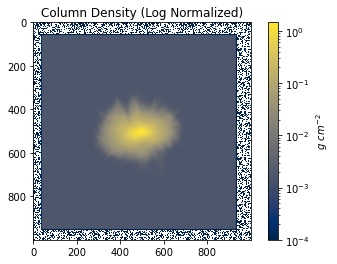

In [6]:
from matplotlib.colors import LogNorm
plt.figure()
plt.imshow(cd, cmap='cividis', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'$g \ cm^{-2}$')
plt.title('Column Density (Log Normalized)')
plt.show()

## 3.2 - Grabbing Proper Model File

General steps here are:
1. Parse the filename for the timestep value
2. Load the interpolated maximum number density data
3. Find the matching row for the timestep value above
4. Grab the maximum number density value

In [7]:
timestep = int(p.name.split('_')[-2])
print(timestep)

# loaded interpolated maximum number density
max_n_file = Path('/Users/samuelfielder/Documents/SyntheticObservations/simulations/_MD_0.4msun/File_Max_n_time_0.4msun_interp.txt')
max_n_interp = np.loadtxt(max_n_file)

# parse the max_n_interp to grab the maximum number density value
ind = np.where(max_n_interp[:,0] == timestep)[0][0]
print(f'Index Value (row) of matched timestep : {ind}')
max_n = max_n_interp[:,3][ind]
print(f'Maximum Number Density Value Found: {max_n:.2e}')

901
Index Value (row) of matched timestep : 1
Maximum Number Density Value Found: 2.09e+07


Next, use this value to load the proper model file of which there are three:

1. `nc8.0_av3.0_N_T_sort.txt` - $ 3.0e6 <= \text{max}(n) <= 3.0e8 $
2. `nc9.0_av3.0_N_T_sort.txt` - $ 3.0e8 <= \text{max}(n) <= 3.0e9 $
3. `nc10.0_av3.0_N_T_sort.txt` - $ 3.0e9 <= \text{max}(n) <= 3.0e10 $

Densities that are lower than $3.0e6$ will raise a ValueError, and any densities above $3e10$ will load the last file in the list above.

I've created a `class` called `ModelData` that is generalizable for all three cases, and just takes in the `max(n)` value above, and creates a `class` where all the information about that specific model.

In [8]:
NC08 = Path('/Users/samuelfielder/Documents/SyntheticObservations/simulations/nc8.0_av3.0_N_T_sort.txt')
NC09 = Path('/Users/samuelfielder/Documents/SyntheticObservations/simulations/nc9.0_av3.0_N_T_sort.txt')
NC10 = Path('/Users/samuelfielder/Documents/SyntheticObservations/simulations/nc10.0_av3.0_N_T_sort.txt')

# just importng here as it is a decent amount of code
from ModelData import ModelData

We can quickly test this `class` by passing in all the regular test cases and the edge cases:

In [9]:
#mod1 = ModelData(2e6)

In [10]:
mod2 = ModelData(4e6)
mod3 = ModelData(4e7)
mod4 = ModelData(4e8)
mod5 = ModelData(4e9)
mod6 = ModelData(4e10)

Input Maximum Number Density: 4.000e+06
Loading NC08 File.
Input Maximum Number Density: 4.000e+07
Loading NC08 File.
Input Maximum Number Density: 4.000e+08
Loading NC09 File.
Input Maximum Number Density: 4.000e+09
Loading NC10 File.
Input Maximum Number Density: 4.000e+10
Loading NC10 File.


As expected, all the correct cases are handled, and report the import form the corresponding matching files.

As far as the models go, they are very similar, although slightly different:

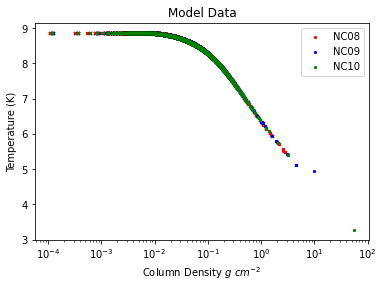

In [11]:
NC08_DATA = np.loadtxt(NC08)
NC09_DATA = np.loadtxt(NC09)
NC10_DATA = np.loadtxt(NC10)

plt.figure()
plt.scatter(NC08_DATA[:,0], NC08_DATA[:,1], c='red', s=5, marker='x', label='NC08')
plt.scatter(NC09_DATA[:,0], NC09_DATA[:,1], c='blue', s=5, marker='x', label='NC09')
plt.scatter(NC10_DATA[:,0], NC10_DATA[:,1], c='green', s=5, marker='x', label='NC10')
plt.xlabel(r'Column Density $g \ cm^{-2}$')
plt.ylabel('Temperature (K)')
plt.title('Model Data')
plt.xscale('log')
plt.legend()
plt.show()

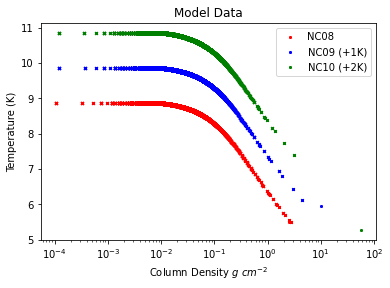

In [12]:
plt.figure()
plt.scatter(NC08_DATA[:,0], NC08_DATA[:,1], c='red', s=5, marker='x', label='NC08')
plt.scatter(NC09_DATA[:,0], NC09_DATA[:,1]+1, c='blue', s=5, marker='x', label='NC09 (+1K)')
plt.scatter(NC10_DATA[:,0], NC10_DATA[:,1]+2, c='green', s=5, marker='x', label='NC10 (+2K)')
plt.xlabel(r'Column Density $g \ cm^{-2}$')
plt.ylabel('Temperature (K)')
plt.title('Model Data')
plt.xscale('log')
plt.legend()
plt.show()

The model data is very similar between all three sets.

## 3.3 - Building the Temperature Maps

`mhdlev8_0.4_flatcol_20kau_0991_0.169468.fits` 

Reminder that the maximum number density was: $3.83e+09$, so we should see the corresponding `NC10` being loaded below.

In [13]:
# column density with cloud
cd_w_cloud = np.add(cd, 0.114)
# initializing temperature array
temp_data_8k = np.zeros(cd.shape)
# build specific model class for this timestep
model_data = ModelData(3.83e9)
# iterate through all pixels
for i in range(cd.shape[0]):
    for j in range(cd.shape[1]):
        # image pixel value
        pix = cd_w_cloud[i,j]
        # update temp_data_7k and temp_data_8k with temperature from model
        temp_data_8k[i,j] = model_data.grabtemperature(pix, TEMP_FLOOR=False)

Input Maximum Number Density: 3.830e+09
Loading NC10 File.


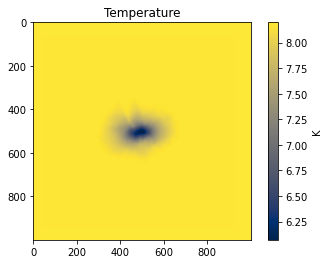

In [14]:
plt.figure()
plt.imshow(temp_data_8k, cmap='cividis')
cbar = plt.colorbar()
cbar.set_label('K')
plt.title('Temperature')
plt.show()

I should also test the floor temperature case, where all pixels that are lower than 7K get replaced by the floor temperature of 7K.

In [15]:
# initializing temperature array
temp_data_7k = np.zeros(cd.shape)
for i in range(cd.shape[0]):
    for j in range(cd.shape[1]):
        # image pixel value
        pix = cd_w_cloud[i,j]
        # update temp_data_7k and temp_data_8k with temperature from model
        temp_data_7k[i,j] = model_data.grabtemperature(pix, TEMP_FLOOR=True)

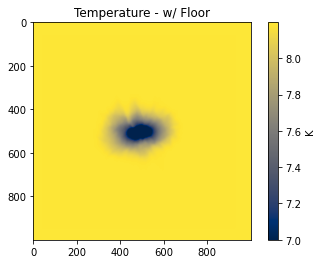

In [16]:
plt.figure()
plt.imshow(temp_data_7k, cmap='cividis')
cbar = plt.colorbar()
cbar.set_label('K')
plt.title('Temperature - w/ Floor')
plt.show()

This has been correctly dealt with here. So it seems as the temperature is correct.

## 3.4 - Planck Function

The Planck Function is computed as the following:

$$
B_{\nu}(T) = \frac{2h\nu^3}{c^2}\frac{1}{\exp{(\frac{h\nu}{k_B \cdot T})} -1}
$$

While the units are usually expressed as:

* $ \text{W} \ \text{m}^{-2} \ \text{sr}^{-1} \ \text{Hz}^{-1} $

These are the SI units, the following values are used instead to be in `cgs`:

* $ h = 6.62607015\times10^{-27} \ \text{cm}^2 \ \text{g} \ \text{s}^{-2} \text{Hz}^{-1} $
* $ c = 2.99792458\times10^{10} \ \text{cm} \ \text{s}^{-1} $
* $ k_B = 1.380649\times10^{-16} \ \text{cm}^2 \ \text{g} \ \text{s}^{-2} \text{K}^{-1} $

These main conversion here is the `Joule` from SI to cgs, mainly:

$ 1\text{J} = 1 \text{kg} \ \text{m}^2 \ \text{s}^{-2} \cdot \left( \frac{100 \ \text{cm}}{1 \ \text{m}} \right)^2 \cdot \left( \frac{1000 \text{g}}{1 \ \text{kg}} \right) = 10^7 \ \text{g} \ \text{cm}^2 \ \text{s}^{-2}$

These are the factors of `7` in the exponents of both the `h` value and the `k_B` value above.

In [17]:
h = 6.62607015e-27 # cm^2 g s^-2 Hz^-1
c = 2.99792458e10 # cm/s
kb = 1.380649e-16 # cm^2 g s^-2 K^-1
nu = 106.0e9 # Hz
planck_8k = ((2*h*(nu**3))/(c**2)) * (1/(np.exp((h*nu)/(kb*temp_data_8k))-1))
planck_7k = ((2*h*(nu**3))/(c**2)) * (1/(np.exp((h*nu)/(kb*temp_data_7k))-1))

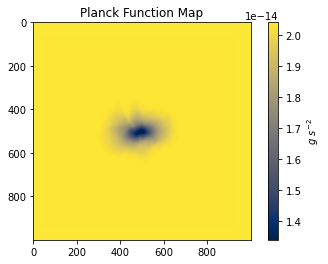

In [18]:
plt.figure()
plt.imshow(planck_8k, cmap='cividis')
cbar = plt.colorbar()
cbar.set_label(r'$g \ s^{-2}$')
plt.title('Planck Function Map')
plt.show()

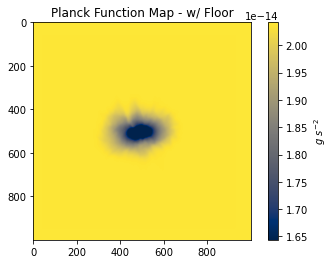

In [19]:
plt.figure()
plt.imshow(planck_7k, cmap='cividis')
cbar = plt.colorbar()
cbar.set_label(r'$g \ s^{-2}$')
plt.title('Planck Function Map - w/ Floor')
plt.show()

## 3.5 - Mass Computation

This is simply computed from the column density. Going from $ g \ cm^{-2}$ to simply a mass, we need the area per pixel.

This is given in the header of the fits file, in the `CDELT1` and `CDELT2` parameters, one for each axis direction.

These values are both: $3e14$ cm.

In [20]:
mass = np.multiply(cd_w_cloud, 3e14*3e14)

This mass is computed using the column density with the cloud value of 0.114 added.

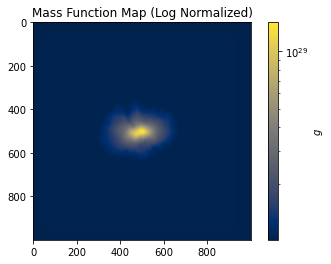

In [21]:
plt.figure()
plt.imshow(mass, cmap='cividis', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'$g$')
plt.title('Mass Function Map (Log Normalized)')
plt.show()

## 3.6 - Final Flux Maps

We use the standard equation to arrive at the final flux values per pixel in the image:

$$
S_{\nu} = \frac{B_{\nu}(T) \cdot \kappa_{\nu} \cdot M}{100 \cdot D^2}
$$

If the units of $B_{\nu}(T)$ are as those mentioned above, then the units of the flux at each pixel will be **grams per second squared**. This means that to get the final answer in **mJy**, which is what Mike has decided in his code, we need a factor out front to scale to mJy:

$$
1\text{Jy} = (10^{-26}) \text{W} \ \text{m}^{-2} \ \text{Hz}^{-1} = 10^{-26} \text{kg} \ \text{s}^{-2} \cdot \left(\frac{1000 \ \text{g}}{\text{kg}}\right) = 10^3 \cdot 10^{-26} \ \text{g} \ \text{s}^{-2} \ .
$$

This means that the extra step to mJy involves:

$$
1\text{Jy} = 10^3 \text{mJy} = 10^3 \cdot 10^{-26} \ \text{g} \ \text{s}^{-2}
$$

Thus the factor in front must be:

$$
1\text{mJy} = 10^{-26} \ \text{g} \ \text{s}^{-2}
$$

Thus, the final equation used to derive the flux is the following:

$$
S_{\nu} = \frac{B_{\nu}(T) \cdot \kappa_{\nu} \cdot M}{100 \cdot D^2} \left[\frac{\text{g}}{\text{s}^{-2}}\right] \cdot \left[\frac{1\text{mJy}}{10^{-26} \ \text{g} \ \text{s}^{-2}}\right] \ ,
$$
$$
S_{\nu} = 10^{26}\frac{B_{\nu}(T) \cdot \kappa_{\nu} \cdot M}{100 \cdot D^2} \ \text{mJy} \ .
$$

Taking the following parameters for the distance and dust opacity:

* $D = 400 \ \text{pc} \cdot \left(\frac{3.0857\times10^{18} \ \text{cm}}{1 \ \text{pc}}\right)= 1.234 \times10^{21} \ \text{cm}$
* $\kappa_{\nu} = 0.23 \ \text{cm}^2 \ \text{g}^{-1}$

In [27]:
kappa = 0.23 # cm^2 g^-1
DISTANCE = 150 * 3.08567758128e18 # cm
flux_8k = 1e26 * mass * planck_8k * kappa / (100*DISTANCE*DISTANCE)
flux_7k = 1e26 * mass * planck_7k * kappa / (100*DISTANCE*DISTANCE)

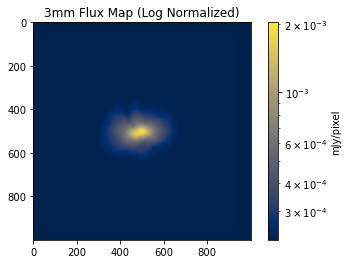

In [23]:
plt.figure()
plt.imshow(flux_8k, cmap='cividis', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label('mJy/pixel')
plt.title('3mm Flux Map (Log Normalized)')
plt.show()

The maximum pixel value of this image is the following:

In [29]:
np.max(flux_8k)

0.0020343385285871308

This is relatively close to the `inbright` parameter that was given in the `simobserve` call:

```python
simobserve(project='sim_0901_0.151293',
skymodel='FITS_IMAGES/0901_0.151293_image.fits',
incell='0.13368984arcsec',
indirection='J2000 11h00m00 -77d20m00',
setpointings=false,
ptgfile='pointings.txt',
incenter='106.0GHz',
inwidth='6GHz',
inbright='0.0019793661mJy/pixel',
integration='1s',
totaltime='72.0s',
antennalist='/sma/casa/data/alma/simmos/alma.cycle1.3.cfg',
thermalnoise='tsys-atm')
```

So it does seem, since his images are in `mJy/pixel`, that `inbright` **does need** to be set, in order for CASA **not** to interpret the image as `Jy/pixel`.